# 隐马尔可夫模型简介（可选项目）
---
### 简介

在此 notebook 中，你将使用 [Pomegranate](http://pomegranate.readthedocs.io/en/latest/index.html) 库构建一个简单的隐马尔可夫模型，并了解 Pomegranate API。

<div class="alert alert-block alert-info">
**注意：**你并非必须完成此 notebook，并且不会与你的项目一期提交，此项目旨在快速介绍 Pomegranate 库的相关部分，你在完成词性标签器时需要用到此库。
</div>

该 notebook 已经包含一些帮助你着手编程的代码。你只需在有标记的地方添加一些新的功能；除此之外，不需要修改所提供的代码。标题中以**实现**开头的部分表明你必须在下面的代码块中提供代码。我们会在每个部分提供说明，并在以 'TODO' 语句开头的代码块中提供实现细节。请务必仔细阅读说明！

<div class="alert alert-block alert-info">
**注意：**可以通过 `Shift + Enter` 键盘快捷键执行代码和标记单元格，也可以通过双击单元格进入编辑模式，编辑标记单元格。
</div>
<hr>

<div class="alert alert-block alert-warning">
**注意：**确保在 Workspace 中选择 **Python 3** 内核，如果你是在自己的机子上运行 Jupyter 服务器，则选择 hmm-tagger conda 环境。
</div>

In [9]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%aimport helpers
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np

from helpers import show_model
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## 构建简单的 HMM
---
你首先将根据教科书[人工智能：现代方法](http://aima.cs.berkeley.edu/)中的示例构建一个简单的 HMM 网络。

> 你是秘密地下设施的保安。每天，你都要猜测今天下雨了吗，但是你接触外面世界的唯一方式是每天早上看到总监是否拿着一把伞。

下图显示了所需网络拓扑的简化图表。

![](_example.png)

### 描述网络

<div class="alert alert-block alert-warning">
$\lambda = (A, B)$ 指定了隐马尔可夫模型，发射概率分布是 $A$，状态转移概率分布是 $B$。
</div>

HMM 网络的参数是两个分布：发射概率 - 给出观察每个隐藏状态的证据值的条件概率，以及转移概率 - 给出在序列期间在状态之间移动的条件概率。此外，你可以指定初始分布，用于描述序列从每个状态开始的概率。

<div class="alert alert-block alert-warning">
在每个时间 $t$, $X_t$ 表示隐藏状态，$Y_t$ 表示该时间的观察结果。
</div>

在此问题中，$t$ 对应的是一周的每一天，隐藏状态表示外面的天气（雨天还是晴天），观察结果记录的是保安是否看到总监拿着伞。

例如，在某一周，保安观察到拿伞的情况是周一到周五 ['是', '否', '是', '否', '是']，外面的天气是 ['雨天', '晴天', '晴天', '晴天', '雨天']。在这种情况下，$t=周三$，$Y_{周三}=是$ 以及 $X_{周三}=晴天$。（你可能觉得奇怪的是，在晴天也看到拿着伞，但是在此模型中是可能发生的。）

### 使用 Pomegranate 初始化 HMM 网络
Pomegranate 库支持[两个初始化方法](http://pomegranate.readthedocs.io/en/latest/HiddenMarkovModel.html#initialization)。你可以明确提供三个分布，或者逐行构建网络。对于示例网络，我们将使用逐行方法，但是你可以使用任何一种方法构建词性标签器。

In [11]:
# create the HMM model
model = HiddenMarkovModel(name="Example Model")

### **实现**：添加隐藏状态
逐行指定 HMM 模型时，对象一开始是空的容器。第一步是命名每个状态，并附上发射分布。

#### 观察量发射概率：$P(Y_t | X_t)$
我们必须假设对于总监的行为，我们知道一些先验信息（可能来自于某个数据集），以便得出每个隐藏状态的发射概率。在实际问题中，你通常可以根据经验估计发射概率，对于词性标签器来说我们将这么做。我们的假想数据将生成下表中的条件概率。（注意行值的和是 1.0）

| |  $是$  | $否$ |
| --- | --- | --- |
| $晴天$ |   0.10  | 0.90 |
| $雨天$ | 0.80 | 0.20 |

In [12]:
# create the HMM model
model = HiddenMarkovModel(name="Example Model")

# emission probability distributions, P(umbrella | weather)
sunny_emissions = DiscreteDistribution({"yes": 0.1, "no": 0.9})
sunny_state = State(sunny_emissions, name="Sunny")

# TODO: create a discrete distribution for the rainy emissions from the probability table
# above & use that distribution to create a state named Rainy
rainy_emissions = DiscreteDistribution({"yes": 0.8, "no": 0.2})
rainy_state = State(rainy_emissions, name="Rainy")

# add the states to the model
model.add_states(sunny_state, rainy_state)

assert rainy_emissions.probability("yes") == 0.8, "The director brings his umbrella with probability 0.8 on rainy days"
print("Looks good so far!")

Looks good so far!


In [13]:
Looks good so far!


SyntaxError: invalid syntax (<ipython-input-13-aa27b2a61f01>, line 1)

### **实现：**添加转移
将状态添加到模型中后，我们可以构建单个状态转移的期望拓扑图。

#### 初始概率 $P(X_0)$：
我们假设不知道关于序列以每个状态开始的似然率方面的实用信息。如果序列每周从周一开始并在周五结束（因此每周是个新的序列），那么这个假设表明周一天气是雨天或晴天的概率是一样的。我们可以设置 $P(X_0=雨天) = 0.5$ 和 $P(X_0=晴天)=0.5$，为每个起始状态分配相等的概率：

| $晴天$ | $雨天$ |
| --- | ---|
| 0.5 | 0.5 |

#### 状态转移概率 $P(X_{t} | X_{t-1})$
最后，我们将假设对此示例来说，我们可以根据该区域的历史天气数据估计转移概率。在实际问题中，你通常可以使用问题结构（例如语言语法）对转移概率设定限制，然后通过用来估算发射概率的相同训练数据重新估算参数。在此假设下，我们得出下表中的条件概率。（注意行值的和是 1.0）

| | $晴天$ | $雨天$ |
| --- | --- | --- |
|$晴天$| 0.80 | 0.20 |
|$雨天$| 0.40 | 0.60 |

In [14]:
# create edges for each possible state transition in the model
# equal probability of a sequence starting on either a rainy or sunny day
model.add_transition(model.start, sunny_state, 0.5)
model.add_transition(model.start, rainy_state, 0.5)

# add sunny day transitions (we already know estimates of these probabilities
# from the problem statement)
model.add_transition(sunny_state, sunny_state, 0.8)  # 80% sunny->sunny
model.add_transition(sunny_state, rainy_state, 0.2)  # 20% sunny->rainy

# TODO: add rainy day transitions using the probabilities specified in the transition table
model.add_transition(rainy_state, sunny_state, 0.4)  # 40% rainy->sunny
model.add_transition(rainy_state, rainy_state, 0.6)  # 60% rainy->rainy

# finally, call the .bake() method to finalize the model
model.bake()

assert model.edge_count() == 6, "There should be two edges from model.start, two from Rainy, and two from Sunny"
assert model.node_count() == 4, "The states should include model.start, model.end, Rainy, and Sunny"
print("Great! You've finished the model.")

Great! You've finished the model.


In [8]:
Great! You've finished the model.


SyntaxError: invalid syntax (<ipython-input-8-5e23c1ef8e9c>, line 1)

## 可视化网络
---
我们提供了一个叫做 `show_model()` 的辅助函数，它会根据 Pomegranate HMM 网络生成 PNG 图像。你可以指定可选文件名以将该文件保存到磁盘上。将“show_ends”参数设为 True 将添加包含在每个 Pomegranate 网络中的模型起始和结束状态。

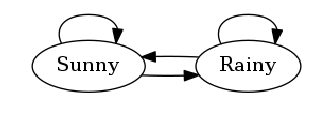

In [15]:
show_model(model, figsize=(5, 5), filename="example.png", overwrite=True, show_ends=False)

![png](output_11_0.png)


### 检查模型
可以通过对 `HMM.states` 属性使用数组语法访问模型状态，并通过调用 `HMM.dense_transition_matrix()` 访问转移矩阵。元素 $(i, j)$ 存储的是从状态 $i$ 转移到状态 $j$ 的概率。例如，指定默认的列顺序后，元素 $(2, 1)$ 给出了从“雨天”转移到“晴天”的概率，我们指定为 0.4。

请运行下面的单元格，检查完整的状态转移矩阵，然后阅读。

In [1]:
column_order = ["Example Model-start", "Sunny", "Rainy", "Example Model-end"]  # Override the Pomegranate default order
column_names = [s.name for s in model.states]
order_index = [column_names.index(c) for c in column_order]

# re-order the rows/columns to match the specified column order
transitions = model.dense_transition_matrix()[:, order_index][order_index, :]
print("The state transition matrix, P(Xt|Xt-1):\n")
print(transitions)
print("\nThe transition probability from Rainy to Sunny is {:.0f}%".format(100 * transitions[2, 1]))

NameError: name 'model' is not defined

In [ ]:
The state transition matrix, P(Xt|Xt-1):

[[0.  0.5 0.5 0. ]
 [0.  0.8 0.2 0. ]
 [0.  0.4 0.6 0. ]
 [0.  0.  0.  0. ]]

The transition probability from Rainy to Sunny is 40%


## 隐马尔可夫模型中的推理
---
在继续之前，我们将通过这个简单的网络快速讲解下如何使用 Pomegranate API 执行最常见的 HMM 任务：

<div class="alert alert-block alert-info">
**似然率评估**<br>
给定模型 $\lambda=(A,B)$ 和一组观察结果 $Y$，计算从模型中观察到该序列的概率 $P(Y|\lambda)$
</div>

我们可以使用天气预测模型评估序列[是, 是, 是, 是, 是] （或任何其他状态序列）的似然率。机器翻译等问题通常会使用似然率和统计学语言模型来解释权重。

<div class="alert alert-block alert-info">
**隐藏状态解码**<br>
给定模型 $\lambda=(A,B)$ 和一组观察结果 $Y$，确定 $Q$，即模型中生成观察值的概率最高隐藏状态序列
</div>

我们可以使用天气预测模型判断已知观察序列的雨天/晴天状态概率最高的序列，例如[是, 否] -> [雨天, 晴天]。我们将在词性标签器中使用解码判断序列的每个单词的标签。编码可以继续拆分为以下部分：“平滑”，计算过去的状态；“过滤”，计算当前状态；“预测”，计算未来状态。 

<div class="alert alert-block alert-info">
**参数学习**<br>
给定模型拓扑图（状态和连接集合）和一组观察结果 $Y$，学习模型的转移概率 $A$ 和发射概率 $B$，$\lambda=(A,B)$
</div>

对于天气问题或词性标注问题，我们不需要学习模型参数，但是 Pomegranate 支持这一功能。

### 实现：计算序列似然率

我们可以使用[前向算法](https://en.wikipedia.org/wiki/Forward_algorithm)计算 HMM 网络的观察序列的似然率。Pomegranate 提供了 `HMM.forward()` 方法，用于计算显示在 HMM 中匹配每个观察量和每个状态的似然率的完整矩阵，以及 `HMM.log_probability()` 方法，用于计算指定模型生成观察序列的所有可能隐藏状态路径的累积似然率。

请在下个部分填写示例观察序列代码，然后使用 `forward()` 和 `log_probability()` 方法评估序列。

In [ ]:
# TODO: input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

assert len(observations) > 0, "You need to choose a sequence of 'yes'/'no' observations to test"

# TODO: use model.forward() to calculate the forward matrix of the observed sequence,
# and then use np.exp() to convert from log-likelihood to likelihood
forward_matrix = np.exp(model.forward(observations))

# TODO: use model.log_probability() to calculate the all-paths likelihood of the
# observed sequence and then use np.exp() to convert log-likelihood to likelihood
probability_percentage = np.exp(model.log_probability(observations))

# Display the forward probabilities
print("         " + "".join(s.name.center(len(s.name)+6) for s in model.states))
for i in range(len(observations) + 1):
    print(" <start> " if i==0 else observations[i - 1].center(9), end="")
    print("".join("{:.0f}%".format(100 * forward_matrix[i, j]).center(len(s.name) + 6)
                  for j, s in enumerate(model.states)))

print("\nThe likelihood over all possible paths " + \
      "of this model producing the sequence {} is {:.2f}%\n\n"
      .format(observations, 100 * probability_percentage))

In [ ]:
Rainy      Sunny      Example Model-start      Example Model-end   
     <start>      0%         0%               100%                     0%          
       yes       40%         5%                0%                      0%          
        no        5%        18%                0%                      0%          
       yes        5%         2%                0%                      0%          

The likelihood over all possible paths of this model producing the sequence ['yes', 'no', 'yes'] is 6.92%

​    


### 实现：解码最可能的隐藏状态序列

[维特比算法](https://en.wikipedia.org/wiki/Viterbi_algorithm)会计算生成特定观察序列似然率最高的单个路径。Pomegranate 提供了 `HMM.viterbi()` 方法，用于计算隐藏状态序列和对应的维特比路径的似然率。

这称之为“解码”，因为我们使用观察序列解码相应的隐藏状态序列。对于词性标注问题来说，隐藏状态映射到词性，观察结果映射到句子。给定一个句子，维特比解码会找到对应于该句子的概率最高的词性标签序列。

请在下个部分填写在上方用过的相同示例观察序列代码，然后使用 `model.viterbi()` 方法计算似然率和最有可能的状态序列。将观察序列的维特比似然率与前向算法似然率进行比较。

In [ ]:
# TODO: input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

# TODO: use model.viterbi to find the sequence likelihood & the most likely path
viterbi_likelihood, viterbi_path = model.viterbi(observations)

print("The most likely weather sequence to have generated " + \
      "these observations is {} at {:.2f}%."
      .format([s[1].name for s in viterbi_path[1:]], np.exp(viterbi_likelihood)*100)
)

In [ ]:
The most likely weather sequence to have generated these observations is ['Rainy', 'Sunny', 'Rainy'] at 2.30%.


### 前向似然率与维特比似然率
运行以下单元格，看看每个观察序列（长度为 3）的似然率，并与维特比路径进行比较。

In [ ]:
from itertools import product

observations = ['no', 'no', 'yes']

p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is...".format(o))
for s in product(*[['Sunny', 'Rainy']]*3):
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

In [ ]:
The likelihood of observing ['no', 'no', 'yes'] if the weather sequence is...
	('Sunny', 'Sunny', 'Sunny') is 2.59% 
	('Sunny', 'Sunny', 'Rainy') is 5.18%  <-- Viterbi path
	('Sunny', 'Rainy', 'Sunny') is 0.07% 
	('Sunny', 'Rainy', 'Rainy') is 0.86% 
	('Rainy', 'Sunny', 'Sunny') is 0.29% 
	('Rainy', 'Sunny', 'Rainy') is 0.58% 
	('Rainy', 'Rainy', 'Sunny') is 0.05% 
	('Rainy', 'Rainy', 'Rainy') is 0.58% 

The total likelihood of observing ['no', 'no', 'yes'] over all possible paths is 10.20%


### 恭喜！
你已经完成了 HMM 准备工作。你应该已经掌握完成词性标签器项目所需的所有工具。